# Movie Recommendation Sytem by Collaborative filtering technique

## 1. Importing Libraries and Loading the Dataset

In [1]:
!pip install fuzzywuzzy

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from fuzzywuzzy import process
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# loading the dataset

Imdb_user_movie_ratings = pd.read_csv('/content/drive/MyDrive/IMDB_Movie_Lens/IMDB_User_Movie_Ratings.csv')
Imdb_movies = pd.read_csv('/content/drive/MyDrive/IMDB_Movie_Lens/IMDB_Movies.csv')

## 2. Exploratory Data Analysis

In [5]:
n_ratings = len(Imdb_user_movie_ratings)
n_movies = Imdb_user_movie_ratings['movieId'].nunique()
n_users = Imdb_user_movie_ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique Movies: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique Movies: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### Distribution of movie ratings

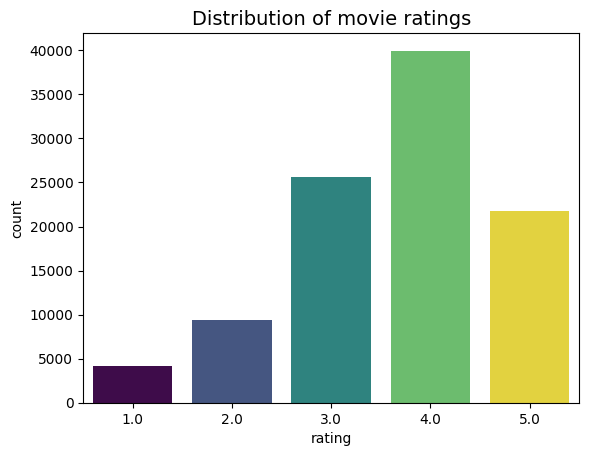

In [6]:
sns.countplot(x="rating", hue="rating", data=Imdb_user_movie_ratings, palette="viridis", legend=False)

plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [7]:
mean_global_rating = Imdb_user_movie_ratings['rating'].mean()
print(f"Mean global rating: {round(mean_global_rating,2)}.")

mean_ratings = Imdb_user_movie_ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.65.
Mean rating per user: 3.78.


## A Glimpse at Movie Genre
The movies dataset needs to be cleaned in two ways:

`genres` is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.

In [8]:
# Using str.split() to extract the genres
Imdb_movies['genres'] = Imdb_movies['genres'].apply(lambda x: x.split('|'))

# Removing the year with help of regular expressions
# Imdb_movies['year'] = Imdb_movies['title'].str.extract(r'\((\d{4})\)')
# Imdb_movies['title'] = Imdb_movies['title'].str.replace(r'\(\d{4}\)', ' ',regex=True).str.strip()

Imdb_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [9]:
# Total no of Movie genres and their count
genre_frequency = Counter(g for genres in Imdb_movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")
genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [10]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


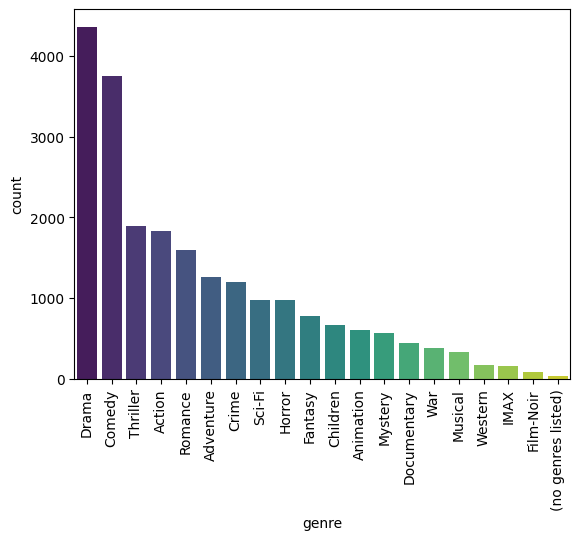

In [11]:
# Visualizing the Genre plot
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False),palette=sns.color_palette("viridis", n_colors=len(genre_frequency_df)))
plt.xticks(rotation=90)
plt.show()

## 3. Popularity Based Recommendation

### Most Frequently Rated movies

In [12]:
# Merging the two dataframes
movie_ratings = Imdb_user_movie_ratings.merge(Imdb_movies, on='movieId')
movie_ratings_count = movie_ratings.groupby('title').agg(rating_count=('rating', 'count')).reset_index()
movie_ratings_count.head(10)

,title,rating_count
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2
5,'Tis the Season for Love (2015),1
6,"'burbs, The (1989)",17
7,'night Mother (1986),1
8,(500) Days of Summer (2009),42
9,*batteries not included (1987),7


### Lowest and Highest Rated Movies

In [13]:
mean_ratings = Imdb_user_movie_ratings.groupby('movieId').agg(mean_rating=('rating', 'mean')).reset_index()
mean_ratings

,movieId,mean_rating
0,1,4.027907
1,2,3.581818
2,3,3.346154
3,4,2.428571
4,5,3.142857
...,...,...
9719,193581,4.000000
9720,193583,4.000000
9721,193585,4.000000
9722,193587,4.000000


In [14]:
# Lowest rated Movie
lowest_rated_movie_id = mean_ratings.loc[mean_ratings['mean_rating'].idxmin(), 'movieId']
Imdb_movies[Imdb_movies['movieId'] == lowest_rated_movie_id]

,movieId,title,genres
150,178,Love & Human Remains (1993),"[Comedy, Drama]"


In [15]:
# Highest Rated Movie
highest_rated_movie_id = mean_ratings.loc[mean_ratings['mean_rating'].idxmax(), 'movieId']
Imdb_movies[Imdb_movies['movieId'] == highest_rated_movie_id]

,movieId,title,genres
48,53,Lamerica (1994),"[Adventure, Drama]"


In [16]:
# How many rating does 'Lamerica (1994)' does have ?
Imdb_user_movie_ratings[Imdb_user_movie_ratings['movieId'] == highest_rated_movie_id]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


## 4. Data Pre-Processing for Collaborative Filtering

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things.

The first step is to transform our data into a user-item matrix, also known as a `utility` matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.

<img src="images/user_movie_matrix.png" width=50%/>

In [19]:
'''
The create_utility_matrix() function generates a sparse matrix X along with four dictionary mappings:

user_mapper: Associates each user ID with a corresponding user index.
movie_mapper: Associates each movie ID with a corresponding movie index.
user_inv_mapper: Provides a reverse mapping from user index back to the original user ID.
movie_inv_mapper: Provides a reverse mapping from movie index back to the original movie ID.

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.
'''

# Sparse Matrix: Only stores non-zero values and their indices, making it memory-efficient for large matrices with few non-zero elements.

def build_utility_matrix(df):

    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_indices = list(range(N))
    movie_indices = list(range(M))

    # Mapping unique userIDs and movieIDs to integer indices
    user_mapper = dict(zip(np.unique(df["userId"]), user_indices))
    movie_mapper = dict(zip(np.unique(df["movieId"]), movie_indices))

    # Reverse mapping from integer indices back to the original IDs
    user_inv_mapper = dict(zip(user_indices, np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(movie_indices, np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    # Constructing the utility matrix as a sparse matrix
    X = csr_matrix((df["rating"], (user_index,movie_index)), shape=(N,M))
    # row -> users
    # columns -> movies

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = build_utility_matrix(Imdb_user_movie_ratings)

In [34]:
# print(X)
print(X.shape)

# X.nnz returns No of Non-Zero elements
NNZ = X.nnz

# print(n_ratings) -> 100836
# The sparsity of a matrix refers to the proportion of zero elements in the matrix
total_elements = X.shape[0] * X.shape[1]
sparsity_ratio = 1 - (NNZ / total_elements)
print(f"Sparsity of Matrix: {round(sparsity_ratio*100,2)}%")

(610, 9724)
Sparsity of Matrix: 98.3%


In [39]:
'''
Checking for Cold Start Problem
The cold start problem is when there are new users and movies in our matrix that do not have any ratings.
'''

#  Number of non-zero elements per row
n_ratings_per_user = X.getnnz(axis=1)
print(len(n_ratings_per_user))
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

610
Most active user rated 2698 movies.
Least active user rated 20 movies.


In [40]:
#  Number of non-zero elements per column
n_ratings_per_movie = X.getnnz(axis=0)

print(len(n_ratings_per_movie))
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

9724
Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


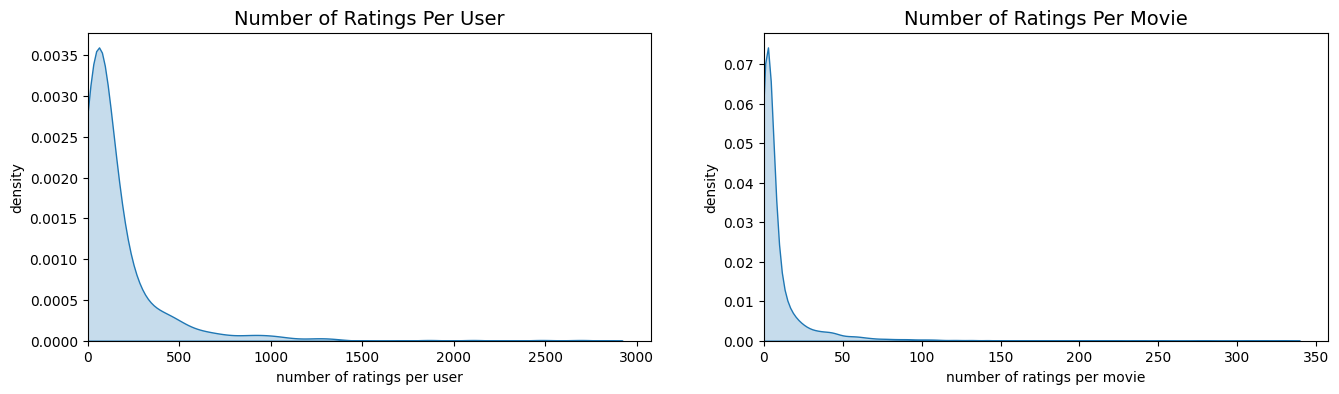

In [41]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")

plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

## 5. Collaborative Filtering Technique: k-Nearest Neighbors for Movie Recommendations (Item-Item Based)

In [57]:
# We are going to find the k movies that have the most similar user engagement vectors for movie

# find_similar_movies() takes in a movieId and X matrix, and outputs a list of  k  movies that are similar to the movieId of interest.
def find_similar_movies(movie_id, X, k, movie_mapper=movie_mapper, movie_inv_mapper=movie_inv_mapper, metric='cosine'):

    X = X.T
    neighbour_ids = []

    movie_idx = movie_mapper.get(movie_id)
    if movie_idx is None:
        raise ValueError(f"Movie ID {movie_id} not found in movie_mapper.")

    movie_vec = X[movie_idx]

    # Convert movie_vec to a 2D array
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)

    knn = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    knn.fit(X)

    # Find k nearest neighbors
    distances, indices = knn.kneighbors(movie_vec, return_distance=True)

    similar_movie_ids = [movie_inv_mapper[idx] for idx in indices.flatten()]

    similar_movie_ids.pop(0)

    return similar_movie_ids,distances.flatten()[1:]


In [58]:
similar_movies, distances = find_similar_movies(1, X, k=10)
print(similar_movies)
print(distances)

[3114, 480, 780, 260, 356, 364, 1210, 648, 4306, 1265]
[0.42103395 0.43025257 0.43711216 0.44137969 0.44781784 0.45256495
 0.45594301 0.46047843 0.46081393 0.46623854]


In [59]:
movie_titles = dict(zip(Imdb_movies['movieId'], Imdb_movies['title']))

movie_id = 1

similar_movies, _ = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Shrek (2001)
Groundhog Day (1993)


In [60]:
# Using Euclidean Distance as metric
movie_id = 1

similar_movies, _ = find_similar_movies(movie_id, X, k=10,metric='euclidean')
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Bug's Life, A (1998)
Independence Day (a.k.a. ID4) (1996)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Mask, The (1994)
Groundhog Day (1993)
Honey, I Shrunk the Kids (1989)


Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, jumanji is actually listed as 'Jumanji (1995)'. If we misspell  jumanji, our recommender won't be able to identify which movie we're interested in.

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in.

Creating a function called `movie_finder()` which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

In [62]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = Imdb_movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [64]:
movie_title = movie_finder("jumndi")
print(movie_title)
movie_id = Imdb_movies.loc[Imdb_movies['title'] == movie_title, 'movieId'].iloc[0]
print(movie_id)

Jumanji (1995)
2


In [68]:
# Try with an example
movie_title = input('Enter a movie You have watched and want similar recommendations : ')
movie_title = movie_finder(movie_title)
movie_id = Imdb_movies.loc[Imdb_movies['title'] == movie_title, 'movieId'].iloc[0]

similar_movies, _ = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print()
print(f"Because you watched '{movie_title}', similar recommendations are:")
for i in similar_movies:
    print(movie_titles[i])

Enter a movie You have watched and want similar recommendations : iron man

Because you watched 'Iron Man (2008)', similar recommendations are:
Dark Knight, The (2008)
WALL·E (2008)
Avengers, The (2012)
Iron Man 2 (2010)
Avatar (2009)
Batman Begins (2005)
Up (2009)
Thor (2011)
Guardians of the Galaxy (2014)
Star Trek (2009)


## 6. Dimensionality Reduction with Matrix Factorization